# Hyperparameter Tuning {#sec-hyperparameter-tuning}

Hyperparameter tuning is an important, but often difficult and computationally intensive task.
Changing the architecture of a neural network or the learning rate of an optimizer can have a significant impact on the performance .

The goal of hyperparameter tuning is to optimize the hyperparameters in a way that improves the performance of the machine learning or deep learning model.
The simplest, but also most computationally expensive, approach uses manual search (or trial-and-error [@Meignan:2015vp]).
Commonly encountered is simple random search, i.e., random and repeated selection of hyperparameters for evaluation, and lattice search ("grid search").
In addition, methods that perform directed search  and other model-free algorithms, i.e., algorithms that do not explicitly rely on a model, e.g., evolution strategies [@Bart13j] or pattern search [@Torczon00] play an important role.
Also, "hyperband", i.e., a multi-armed bandit strategy that dynamically allocates resources to a set of random configurations and uses successive bisections to stop configurations with poor performance [@Li16a], is very common in hyperparameter tuning.
The most sophisticated and efficient approaches are the Bayesian optimization and surrogate model based optimization methods, which are based on the optimization of cost functions determined by simulations or experiments.

We consider below a surrogate model based optimization-based hyperparameter tuning approach based on the Python version of the SPOT ("Sequential Parameter Optimization Toolbox") [@BLP05], which is suitable for situations where only limited resources are available. This may be due to limited availability and cost of hardware, or due to the fact that confidential data may only be processed locally, e.g., due to legal requirements.
Furthermore, in our approach, the understanding of algorithms is seen as a key tool for enabling transparency and explainability. This can be enabled, for example, by quantifying the contribution of machine learning and deep learning components (nodes, layers, split decisions, activation functions, etc.).
Understanding the importance of hyperparameters and the interactions between multiple hyperparameters plays a major role in the interpretability and explainability of machine learning models.
SPOT provides statistical tools for understanding hyperparameters and their interactions. Last but not least, it should be noted that the SPOT software code is available in the open source `spotPython` package on github^[[https://github.com/sequential-parameter-optimization](https://github.com/sequential-parameter-optimization)], allowing replicability of the results.
This tutorial descries the Python variant of SPOT, which is called `spotPython`. The R implementation is described in @bart21i.
SPOT is an established open source software that has been maintained for more than 15 years [@BLP05] [@bart21i].

This tutorial is structured as follows. The concept of the hyperparameter tuning software `spotPython` is described in @sec-spot. @sec-hyperparameter-tuning-for-pytorch describes the integration of `spotPython` into the ``PyTorch`` training workflow and presents the results. Finally, @sec-summary presents a summary and an outlook.

::: {.callout-note}
The corresponding ` .ipynb` notebook [@bart23e] is updated regularly and reflects updates and changes in the `spotPython` package.
It can be downloaded from [https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb](https://github.com/sequential-parameter-optimization/spotPython/blob/main/notebooks/14_spot_ray_hpt_torch_cifar10.ipynb).
:::


# The Hyperparameter Tuning Software SPOT {#sec-spot}

Surrogate model based optimization methods are common approaches in simulation and optimization. SPOT was developed because there is a great need for sound statistical analysis of simulation and optimization algorithms. SPOT includes methods for tuning based on classical regression and analysis of variance techniques.
It presents tree-based models such as classification and regression trees and random forests as well as Bayesian optimization (Gaussian process models, also known as Kriging). Combinations of different meta-modeling approaches are possible. SPOT comes with a sophisticated surrogate model based optimization method, that can handle discrete and continuous inputs. Furthermore, any model implemented in `scikit-learn` can be used out-of-the-box as a surrogate in `spotPython`.

SPOT implements key techniques such as exploratory fitness landscape analysis and sensitivity analysis. It can be used to understand the performance of various algorithms, while simultaneously giving insights into their algorithmic behavior.
In addition, SPOT can be used as an optimizer and for automatic and interactive tuning. Details on SPOT and its use in practice are given by @bart21i.

A typical hyperparameter tuning process with `spotPython` consists of the following steps:

1. Loading the data (training and test datasets), see @sec-data-loading.
2. Specification of the preprocessing model, see @sec-specification-of-preprocessing-model. This model is called `prep_model` ("preparation" or pre-processing).
The information required for the hyperparameter tuning is stored in the dictionary `fun_control`. Thus, the information needed for the execution of the hyperparameter tuning is available in a readable form.
3. Selection of the machine learning or deep learning model to be tuned, see @sec-selection-of-the-algorithm. This is called the `core_model`. Once the `core_model` is defined, then the associated hyperparameters are stored in the `fun_control` dictionary. First, the hyperparameters of the `core_model` are initialized with the default values of the `core_model`.
As default values we use the default values contained in the `spotPython` package for the algorithms of the `torch` package.
4. Modification of the default values for the hyperparameters used in `core_model`, see @sec-modification-of-default-values. This step is optional.
   1. numeric parameters are modified by changing the bounds.
   2. categorical parameters are modified by changing the categories ("levels").
5. Selection of target function (loss function) for the optimizer, see @sec-selection-of-target-function.
6. Calling SPOT with the corresponding parameters, see @sec-call-the-hyperparameter-tuner. The results are stored in a dictionary and are available for further analysis.
7. Presentation, visualization and interpretation of the results, see @sec-results-tuning.

# Hyperparameter Tuning for PyTorch With `spotPython` {#sec-hyperparameter-tuning-for-pytorch}

In this tutorial, we will show how `spotPython` can be integrated into the `PyTorch`
training workflow. It is based on the tutorial "Hyperparameter Tuning with Ray Tune" from the `PyTorch` documentation [@pyto23a], which is an extension of the tutorial "Training a Classifier" [@pyto23b] for training a CIFAR10 image classifier.

This document refers to the following software versions:

- ``python``: 3.10.10
- ``torch``: 2.0.1
- ``torchvision``: 0.15.0
- ``spotPython``: 0.1.3

`spotPython` can be installed via pip^[Alternatively, the source code can be downloaded from gitHub: [https://github.com/sequential-parameter-optimization/spotPython](https://github.com/sequential-parameter-optimization/spotPython).].

```{raw}
!pip install spotPython
```

Results that refer to the `Ray Tune` package are taken from [https://PyTorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html](https://PyTorch.org/tutorials/beginner/hyperparameter_tuning_tutorial.html)^[We were not able to install `Ray Tune` on our system. Therefore, we used the results from the `PyTorch` tutorial.].

## Setup {#sec-setup}

Before we consider the detailed experimental setup, we select the parameters that affect run time, initial design size and the device that is used.

In [1]:
MAX_TIME = 60
INIT_SIZE = 10
DEVICE = "cpu" # "cuda:0"

In [2]:
#| echo: false
import os
import copy
import pickle
import socket
from datetime import datetime
from dateutil.tz import tzlocal
start_time = datetime.now(tzlocal())
HOSTNAME = socket.gethostname().split(".")[0]
experiment_name = '14-torch' + "_" + HOSTNAME + "_" + str(MAX_TIME) + "min_" + str(INIT_SIZE) + "init_" + str(start_time).split(".", 1)[0].replace(' ', '_')
experiment_name = experiment_name.replace(':', '-')
print(experiment_name)
if not os.path.exists('./figures'):
    os.makedirs('./figures')

14-torch_maans03_60min_10init_2023-05-19_16-34-33


In [3]:
#| echo: false
from tabulate import tabulate
import warnings
import json
import numpy as np
from math import inf
import pandas as pd

from scipy.optimize import differential_evolution

import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import random_split
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.transforms import ToTensor

from spotPython.spot import spot
from spotPython.hyperparameters.values import (
    add_core_model_to_fun_control,
    assign_values,
    get_bound_values,
    get_default_values,
    get_default_hyperparameters_as_array,
    get_var_name,
    get_var_type,
    modify_hyper_parameter_levels,
    modify_hyper_parameter_bounds,
    return_conf_list_from_var_dict,
    get_one_core_model_from_X,
)
from spotPython.torch.traintest import (
    evaluate_cv,
    evaluate_hold_out,
    train_save,
    test_saved,
    )
from spotPython.utils.eda import gen_design_table
from spotPython.utils.transform import transform_hyper_parameter_values
from spotPython.utils.init import fun_control_init

from spotPython.data.torch_hyper_dict import TorchHyperDict
from spotPython.fun.hypertorch import HyperTorch
from spotPython.torch.netcifar10 import Net_CIFAR10

warnings.filterwarnings("ignore")

## Initialization of the `fun_control` Dictionary

`spotPython` uses a Python dictionary for storing the information required for the hyperparameter tuning process. This dictionary is called `fun_control` and is initialized with the function `fun_control_init`. The function `fun_control_init` returns a skeleton  dictionary. The dictionary is filled with the required information for the hyperparameter tuning process. It stores the hyperparameter tuning settings, e.g., the deep learning network architecture that should be tuned, the classification (or regression) problem, and the data that is used for the tuning.
The dictionary is used as an input for the SPOT function.


In [4]:
#| echo: true
fun_control = fun_control_init()

## Data Loading {#sec-data-loading}

The data loading process is implemented in the same manner as described in the Section "Data loaders" in @pyto23a.
The data loaders are wrapped into the function `load_data`. A global data directory is used, which allows sharing the data directory between different trials.

In [5]:
#| echo: true
def load_data(data_dir="./data"):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    trainset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=transform)

    testset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=transform)

    return trainset, testset

The test and train data are added to the dictionary `fun_control`.


In [6]:
#| echo: true
train, test = load_data()
n_samples = len(train)
# add the dataset to the fun_control
fun_control.update({
    "train": train,
    "test": test,
    "n_samples": n_samples})

Files already downloaded and verified
Files already downloaded and verified


## Specification of the Preprocessing Model {#sec-specification-of-preprocessing-model}

After the training and test data are specified and added to the `fun_control` dictionary, `spotPython` allows the specification of a data preprocessing pipeline, e.g., for the scaling of the data or for the one-hot encoding of categorical variables. The preprocessing model is called `prep_model` ("preparation" or pre-processing) and includes steps that are not subject to the hyperparameter tuning process. The preprocessing model is specified in the `fun_control` dictionary. The preprocessing model can be implemented as a `sklearn` pipeline. The following code shows a typical preprocessing pipeline:

```{raw}
categorical_columns = ["cities", "colors"]
one_hot_encoder = OneHotEncoder(handle_unknown="ignore",
                                    sparse_output=False)
prep_model = ColumnTransformer(
        transformers=[
             ("categorical", one_hot_encoder, categorical_columns),
         ],
         remainder=StandardScaler(),
     )
```

Because the Ray Tune (`ray[tune]`) hyperparameter tuning as described in @pyto23a does not use a preprocessing model, the preprocessing model is set to `None` here.

In [7]:
#| echo: true
prep_model = None
fun_control.update({"prep_model": prep_model})

## Select `algorithm` and `core_model_hyper_dict` {#sec-selection-of-the-algorithm}

The same neural network model as implemented in the section "Configurable neural network" of the `PyTorch` tutorial [@pyto23a] is used here.
We will show the implementation from @pyto23a in @sec-implementation-with-raytune first, before the extended implementation with `spotPython` is shown in @sec-implementation-with-spotpython.


### Implementing a Configurable Neural Network With Ray Tune{#sec-implementation-with-raytune}

We used the same hyperparameters that are implemented as configurable in the `PyTorch` tutorial. We specify the layer sizes, namely `l1` and `l2`, of the fully connected layers:

```{raw}
class Net(nn.Module):
    def __init__(self, l1=120, l2=84):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

```

The learning rate, i.e., `lr`,  of the optimizer is made configurable, too:

```{raw}
optimizer = optim.SGD(net.parameters(), lr=config["lr"], momentum=0.9)
```

### Implementing a Configurable Neural Network With spotPython {#sec-implementation-with-spotpython}

`spotPython` implements a class which is similar to the class described in the `PyTorch` tutorial. The class is called `Net_CIFAR10` and is implemented in the file `netcifar10.py`.

```{raw}
import spotPython.torch.netcore as netcore
class Net_CIFAR10(netcore.Net_Core):
    def __init__(self, l1, l2, lr, batch_size, epochs, k_folds, patience):
        super(Net_CIFAR10, self).__init__(
            lr=lr, batch_size=batch_size, epochs=epochs, k_folds=k_folds,
            patience=patience
        )
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, l1)
        self.fc2 = nn.Linear(l1, l2)
        self.fc3 = nn.Linear(l2, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
```

`Net_CIFAR10` inherits from the class `Net_Core` which is implemented in the file `netcore.py`.  It implements the additional attributes that are common to all neural network models. The attributes are the learning rate `lr`, the batch size `batch_size`, the number of epochs `epochs`, the number of folds `k_folds` for the cross validation, and the patience `patience` for the early stopping. The class `Net_Core` is shown below.

```{raw}
from torch import nn


class Net_Core(nn.Module):
    def __init__(self, lr, batch_size, epochs, k_folds, patience):
        super(Net_Core, self).__init__()
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.k_folds = k_folds
        self.patience = patience
```

### Comparison of the Approach Described in the PyTorch Tutorial With spotPython {#sec-comparison}

Comparing the class `Net` from the `PyTorch` tutorial and the class `Net_CIFAR10` from `spotPython`, we see that the class `Net_CIFAR10` has additional attributes and does not inherit from `nn` directly. It adds an additional class, `Net_core`, that takes care of additional attributes that are common to all neural network models, e.g., the learning rate `lr` or the batch size `batch_size`.

`spotPython`'s `core_model` implements an instance of the `Net_CIFAR10` class. In addition to the basic neural network model, the `core_model` can use these additional attributes.
`spotPython` provides methods for handling these additional attributes to guarantee 100% compatibility with the `PyTorch` classes. The method `add_core_model_to_fun_control` adds the hyperparameters and additional attributes to the `fun_control` dictionary. The method is shown below.

In [8]:
#| echo: true
core_model = Net_CIFAR10
fun_control = add_core_model_to_fun_control(core_model=core_model,
                              fun_control=fun_control,
                              hyper_dict=TorchHyperDict,
                              filename=None)

::: {.callout-note}
In addition to the class Net from the `PyTorch` tutorial, the class Net_CIFAR10 has additional attributes, e.g.:

* learning rate (`lr`),
* batch size (`batch_size`),
* epochs (`epochs`),
* k_folds (`k_folds`), and
* early stopping criterion "patience" (`patience`)

Further attributes can be easily added to the class, e.g., `optimizer` or `loss_function`.
:::

## The Search Space {#sec-search-space}

In @sec-configuring-the-search-space-with-ray-tune, we first describe how to configure the search space with `ray[tune]`  (as shown in @pyto23a) 
and then how to configure the search space with `spotPython` in @sec-configuring-the-search-space-with-spotpython.

### Configuring the Search Space With Ray Tune {#sec-configuring-the-search-space-with-ray-tune}

 Ray Tune's search space can be configured as follows [@pyto23a]:

```{raw}
config = {
    "l1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "l2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "lr": tune.loguniform(1e-4, 1e-1),
    "batch_size": tune.choice([2, 4, 8, 16])
}
```
The ``tune.sample_from()`` function enables the user to define sample
methods to obtain hyperparameters. In this example, the ``l1`` and ``l2`` parameters
should be powers of 2 between 4 and 256, so either 4, 8, 16, 32, 64, 128, or 256.
The ``lr`` (learning rate) should be uniformly sampled between 0.0001 and 0.1. Lastly,
the batch size is a choice between 2, 4, 8, and 16.

At each trial, `ray[tune]` will randomly sample a combination of parameters from these
search spaces. It will then train a number of models in parallel and find the best
performing one among these. `ray[tune]` uses the ``ASHAScheduler`` which will terminate bad
performing trials early.

### Configuring the Search Space With spotPython {#sec-configuring-the-search-space-with-spotpython}

#### The `hyper_dict` Hyperparameters for the Selected Algorithm

`spotPython` uses simple `JSON` files for the specification of the hyperparameters.
Users can specify their individual  `JSON` files, or they can use the `JSON` files provided by `spotPython`.
The `JSON` file for the `core_model` is called `torch_hyper_dict.json`.

Each entry in the `JSON` file represents one hyperparameter with the following structure:
`type`, `default`, `transform`, `lower`, and `upper`.
The corresponding entries for the `Net_CIFAR10` class are shown below.

```json
{"Net_CIFAR10":
    {
        "l1": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "l2": {
            "type": "int",
            "default": 5,
            "transform": "transform_power_2_int",
            "lower": 2,
            "upper": 9},
        "lr": {
            "type": "float",
            "default": 1e-03,
            "transform": "None",
            "lower": 1e-05,
            "upper": 1e-02},
        "batch_size": {
            "type": "int",
            "default": 4,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "epochs": {
            "type": "int",
            "default": 3,
            "transform": "transform_power_2_int",
            "lower": 1,
            "upper": 4},
        "k_folds": {
            "type": "int",
            "default": 2,
            "transform": "None",
            "lower": 2,
            "upper": 3},
        "patience": {
            "type": "int",
            "default": 5,
            "transform": "None",
            "lower": 2,
            "upper": 10},
        "optimizer": {
            "levels": ["Adadelta",
                       "Adagrad",
                       "Adam",
                       "AdamW",
                       "SparseAdam",
                       "Adamax",
                       "ASGD",
                       "LBFGS",
                       "NAdam",
                       "RAdam",
                       "RMSprop",
                       "Rprop",
                       "SGD"],
            "type": "factor",
            "default": "SGD",
            "transform": "None",
            "class_name": "torch.optim",
            "core_model_parameter_type": "str",
            "lower": 0,
            "upper": 12},
        "criterion": {
            "levels": ["L1Loss",
                       "MSELoss",
                       "CrossEntropyLoss",
                       "CTCLoss",
                       "NLLLoss",
                       "PoissonNLLLoss",
                       "GaussianNLLLoss",
                       "KLDivLoss",
                       "BCELoss",
                       "BCEWithLogitsLoss",
                       "MarginRankingLoss",
                       "HingeEmbeddingLoss",
                       "MultiLabelMarginLoss",
                       "HuberLoss",
                       "SmoothL1Loss",
                       "SoftMarginLoss",
                       "MultiLabelSoftMarginLoss",
                       "CosineEmbeddingLoss",
                       "MultiMarginLoss",
                       "TripletMarginLoss",
                       "TripletMarginWithDistanceLoss"],
            "type": "factor",
            "default": "CrossEntropyLoss",
            "transform": "None",
            "class_name": "torch.nn",
            "core_model_parameter_type": "instance()",
            "lower": 0,
            "upper": 20}
    }
}
```


#### Categorical Hyperparameters

In contrast to `ray[tune]`, `spotPython` can handle numerical, boolean, and categorical hyperparameters. Since `ray[tune]` does not tune categorical hyperparameters, they are not used here. However, they can be specified in the `JSON` file in a similar way as the numerical hyperparameters as shown below:

```json
"factor_hyperparameter": {
    "levels": ["A", "B", "C"],
    "type": "factor",
    "default": "B",
    "transform": "None",
    "core_model_parameter_type": "str",
    "lower": 0,
    "upper": 2},
```

## Modifying the Hyperparameters {#sec-modification-of-hyperparameters}

Ray tune [@pyto23a] does not provide a way to change the specified hyperparameters without re-compilation. However, `spotPython` provides functions for modifying the hyperparameters, their bounds and factors as well as for activating and de-activating hyperparameters without re-compilation of the Python source code. These functions are described in the following.

### Modify `hyper_dict` Hyperparameters for the Selected Algorithm aka `core_model` {#sec-modification-of-default-values}

After specifying the model, the corresponding hyperparameters, their types and bounds are loaded from the `JSON` file `torch_hyper_dict.json`. After loading, the user can modify the hyperparameters, e.g., the bounds.
`spotPython` provides a simple rule for de-activating hyperparameters: If the lower and the upper bound are set to identical values, the hyperparameter is de-activated. This is useful for the hyperparameter tuning, because it allows to specify a hyperparameter in the `JSON` file, but to de-activate it in the `fun_control` dictionary. This is done in the next step.


### Modify Hyperparameters of Type numeric and integer (boolean)

Since the hyperparameter `k_folds` is not used in the `PyTorch` tutorial, it is de-activated here by setting the lower and upper bound to the same value. Note, `k_folds` is of type "integer".

In [9]:
#| echo: true
fun_control = modify_hyper_parameter_bounds(fun_control, "batch_size", bounds=[1, 5])
fun_control = modify_hyper_parameter_bounds(fun_control, "k_folds", bounds=[0, 0])
fun_control = modify_hyper_parameter_bounds(fun_control, "patience", bounds=[3, 3])
fun_control["core_model_hyper_dict"]

{'l1': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'l2': {'type': 'int',
  'default': 5,
  'transform': 'transform_power_2_int',
  'lower': 2,
  'upper': 9},
 'lr': {'type': 'float',
  'default': 0.001,
  'transform': 'None',
  'lower': 1e-05,
  'upper': 0.01},
 'batch_size': {'type': 'int',
  'default': 4,
  'transform': 'transform_power_2_int',
  'lower': 1,
  'upper': 5},
 'epochs': {'type': 'int',
  'default': 3,
  'transform': 'transform_power_2_int',
  'lower': 3,
  'upper': 4},
 'k_folds': {'type': 'int',
  'default': 2,
  'transform': 'None',
  'lower': 0,
  'upper': 0},
 'patience': {'type': 'int',
  'default': 5,
  'transform': 'None',
  'lower': 3,
  'upper': 3},
 'optimizer': {'levels': ['Adadelta',
   'Adagrad',
   'Adam',
   'AdamW',
   'SparseAdam',
   'Adamax',
   'ASGD',
   'LBFGS',
   'NAdam',
   'RAdam',
   'RMSprop',
   'Rprop',
   'SGD'],
  'type': 'factor',
  'default': 'SGD',
  'transform': 'None',
  'clas

### Modify Hyperparameter of Type factor

In a similar manner as for the numerical hyperparameters, the categorical hyperparameters can be modified.
New configurations can be chosen by adding or deleting levels. For example, the hyperparameter `optimizer` can be re-configured as follows:

In the following setting, two optimizers (`"SGD"` and `"Adam"`) will be compared during the `spotPython` hyperparameter tuning. The hyperparameter `optimizer` is active.

In [10]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD", "Adam"])

The hyperparameter `optimizer` can be de-activated by choosing only one value (level), here: `"SGD"`.

In [11]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer", ["SGD"])

* As discussed in @sec-optimizers, there are some issues with the LBFGS optimizer. Therefore, the usage of the LBFGS optimizer is not  deactivated in `spotPython` by default. However, the LBFGS optimizer can be activated by adding it to the list of optimizers.
* Rprop  was remmoved, because it does perform very poorly (as some pre-tests have shown). However, it can also be activated by adding it to the list of optimizers.
* Therefore, there are elevendefault optimizers:

In [12]:
#| echo: true
fun_control = modify_hyper_parameter_levels(fun_control, "optimizer",["Adadelta",
     "Adagrad", "Adam", "AdamW", "Adamax", "ASGD", "NAdam", "RAdam",
      "RMSprop", "SGD"])

### Optimizers {#sec-optimizers}

@tbl-optimizers shows some of the optimizers available in `PyTorch`:

| Optimizer | lr  | mom | weight | damp | nest | rho | lr_sc | lr_decay | betas |
| :----- | :--- | :--- | :--- | :--- | :--- | :--- | :--- | :---| :---- |
| SGD | required | float: 0 | float: 0 | float: 0 | bool: False | - | -| -| -|
| Adadelta | - | - | float: 0 | - | - | float: 0.9 | float: 1.0| - | -|
| Adagrad | float: 1e-2 | - | float: 0 | - | - | - | - | float: 0  | -|
| Adam | float: 1e-3 | - | float: 0 | - | - | - | - | -| Tuple[float, float]: (0.9, 0.999) |
| AdamW | float: 1e-3 | - | float: 1e-2 | - | - | - | - | -| Tuple[float, float]: (0.9, 0.999) |
| SparseAdam | float: 1e-3 | - | - | - | - | - | - | -| Tuple[float, float]: (0.9, 0.999) |

: Optimizers available in PyTorch (selection). "mom" denotes `momentum`, "weight" `weight_decay`, "damp" `dampening`, "nest" `nesterov`, and  "lr_sc" `learning rate for scaling delta`.  The default values are shown in the table. {#tbl-optimizers}

`spotPython` implements an `optimization` handler that maps the optimizer names to the corresponding `PyTorch` optimizers.

::: {.callout-note}
### A note on LBFGS

`PyTorch`'s LBFGS optimizer is deactivated in `spotPython` by default, because it does not perform very well. The  `PyTorch` documentation, see [https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS](https://pytorch.org/docs/stable/generated/torch.optim.LBFGS.html#torch.optim.LBFGS), states:

> This is a very memory intensive optimizer (it requires additional `param_bytes * (history_size + 1)` bytes). If it doesn’t fit in memory try reducing the history size, or use a different algorithm.


Furthermore, the LBFGS optimizer is not compatible with the `PyTorch` tutorial. The reason is that the LBFGS optimizer requires the `closure` function, which is not implemented in the `PyTorch` tutorial. Therefore, the `LBFGS` optimizer is recommended here.
:::

Since there are 10 optimizers in the portfolio, it is not recommended tuning the hyperparameters that effect one single optimizer only.
Thus, the learning rate, which affects only the `SGD` optimizer, will be set to a fixed value. We choose the default value of `1e-3` for the learning rate, because this value can befound in `PyTorch` examples.

In [13]:
#| echo: true
fun_control = modify_hyper_parameter_bounds(fun_control, "lr", bounds=[1e-3, 1e-3])

## Evaluation  {#sec-selection-of-target-function}

The evaluation procedure requires the specification of two elements:

1. the way how the data is split into a train and a test set and
2. the loss function (and a metric).

### Hold-out Data Split and Cross-Validation

As a default, `spotPython` provides a standard hold-out data split and cross validation.

#### Hold-out Data Split

If a hold-out data split is used, the data will be partitioned into a training, a validation, and a test data set.
The split depends on the setting of the `eval` parameter. If `eval` is set to `train_hold_out`, one data set, usually the original training data set, is split into a new training and a validation data set. The training data set is used for training the model. The validation data set is used for the evaluation of the hyperparameter configuration and early stopping to prevent overfitting. In this case, the original test data set is not used.
The following splits are performed in the hold-out setting:
$\{\text{train}_0, \text{test}\} \rightarrow \{\text{train}_1, \text{validation}_1, \text{test}\}$, where $\text{train}_1 \cup \text{validation}_1 = \text{train}_0$.


::: {.callout-note}
`spotPython` returns the hyperparameters of the machine learning and deep learning models, e.g., number of layers, learning rate, or optimizer, but not the model weights. Therefore, after the SPOT run is finished, the corresponding model has to be trained again with the best hyperparameter configuration. The training is performed on the training data set. The test data set is used for the final evaluation of the model.

Summarizing, the following splits are performed in the hold-out setting:

1. Run `spotPython` with `eval` set to `train_hold_out` to determine the best hyperparameter configuration.
2. Train the model with the best hyperparameter configuration on the training data set:
   * `train_save(model_spot, train, "model_spot.pt")`.
3. Test the model on the test data:
   * `test_saved(model_spot, test, "model_spot.pt")`

These steps will be exemplified in the following sections.
:::

In addition to this `hold-out` setting, `spotPython` provides another hold-out setting, where an explicit test data is specified by the user that will be used as the validation set. To choose this option, the `eval` parameter is set to `test_hold_out`. In this case, the training data set is used for the model training. Then, the explicitly defined test data set is used for the evaluation of the hyperparameter configuration (the validation).

#### Cross-Validation

The cross validation setting is used by setting the `eval` parameter to `train_cv` or `test_cv`. In both  cases, the data set is split into $k$ folds. The model is trained on $k-1$ folds and evaluated on the remaining fold. This is repeated $k$ times, so that each fold is used exactly once for evaluation. The final evaluation is performed on the test data set. The cross validation setting is useful for small data sets, because it allows to use all data for training and evaluation. However, it is computationally expensive, because the model has to be trained $k$ times.

::: {.callout-note}
Combinations of the above settings are possible, e.g., cross validation can be used for training and hold-out for evaluation or \emph{vice versa}. Also, cross validation can be used for training and testing. Because cross validation is not used in the `PyTorch` tutorial [@pyto23a], it is not considered further here.
:::

### Loss Functions and Metrics

::: {.callout-warning}
#### Use of the Key `"criterion"` is deprecated as of `v.0.1.5`
Starting with version `v.0.1.5` `spotPython` uses the key `"loss_function"` for loss functions instead of `"criterion"`.
:::

The key `"loss_function"` specifies the loss function which is used during the optimization. There are several different loss functions under `PyTorch`'s nn package. For example, a simple loss is `MSELoss`, which computes the mean-squared error between the output and the target. In this tutorial we will use `CrossEntropyLoss`, because it is also used in the `PyTorch` tutorial.

In [14]:
fun_control = modify_hyper_parameter_levels(fun_control, "loss_function", ["CrossEntropyLoss"])

In addition to the loss function, `spotPython` provides access to a large number of metrics. The key `"metric_sklearn"` is used for metrics that follow the `scikit-learn` conventions^[The key `"metric"` is used for the river based evaluation [@mont20a] via `eval_oml_iter_progressive`.].
Because the `PyTorch` tutorial uses the accuracy as metric, we use the same metric here. Currently, accuracy is computed in the tutorial's example code. Therefore, we will use the same implementation here and set the key `"metric_sklearn"` to `None`.

In [15]:
#| echo: true
weights = 1.0
loss_function = CrossEntropyLoss
shuffle = True
eval = "train_hold_out"
device = DEVICE
show_batch_interval = 100_000
save_model = True
path="torch_model.pt"

fun_control.update({
               "data_dir": None,
               "checkpoint_dir": None,
               "horizon": None,
               "oml_grace_period": None,
               "weights": weights,
               "step": None,
               "log_level": 50,
               "weight_coeff": None,
               "metric": None,
               "metric_sklearn": None,
               "loss_function": loss_function,
               "shuffle": shuffle,
               "eval": eval,
               "device": device,
               "show_batch_interval": show_batch_interval,
               "save_model": save_model,
               "path": path,
               })

## Calling the SPOT Function {#sec-call-the-hyperparameter-tuner}

In [16]:
#| echo: false
var_type = get_var_type(fun_control)
var_name = get_var_name(fun_control)
fun_control.update({"var_type": var_type,
                    "var_name": var_name})

lower = get_bound_values(fun_control, "lower")
upper = get_bound_values(fun_control, "upper")

Now, the dictionary `fun_control` contains all information needed for the hyperparameter tuning. Before the hyperparameter tuning is started, it is recommended to take a look at the experimental design. The method `gen_design_table` generates a design table as follows:

In [17]:
#| echo: true
print(gen_design_table(fun_control))

| name       | type   | default          |   lower |   upper | transform             |
|------------|--------|------------------|---------|---------|-----------------------|
| l1         | int    | 5                |   2     |   9     | transform_power_2_int |
| l2         | int    | 5                |   2     |   9     | transform_power_2_int |
| lr         | float  | 0.001            |   0.001 |   0.001 | None                  |
| batch_size | int    | 4                |   1     |   5     | transform_power_2_int |
| epochs     | int    | 3                |   3     |   4     | transform_power_2_int |
| k_folds    | int    | 2                |   0     |   0     | None                  |
| patience   | int    | 5                |   3     |   3     | None                  |
| optimizer  | factor | SGD              |   0     |   9     | None                  |
| criterion  | factor | CrossEntropyLoss |   0     |   0     | None                  |


This allows to check if all information is available and if the information is correct.  @tbl-design shows the experimental design for the hyperparameter tuning. Hyperparameter transformations are shown in the column "transform", e.g., the `l1` default is `5`, which results in the value $2^5 = 32$ for the network, because the transformation ` transform_power_2_int` was selected in the `JSON` file. The default value of the `batch_size` is set to `4`, which results in a batch size of $2^4 = 16$. 


| name       | type   |   default |   lower |   upper | transform             |
|------------|--------|-----------|---------|---------|-----------------------|
| l1         | int    |     5     |   2     |    9    | transform_power_2_int |
| l2         | int    |     5     |   2     |    9    | transform_power_2_int |
| lr         | float  |     0.001 |   1e-05 |    0.01 | None                  |
| batch_size | int    |     4     |   1     |    4    | transform_power_2_int |
| epochs     | int    |     3     |   3     |    4    | transform_power_2_int |
| k_folds    | int    |     2     |   0     |    0    | None                  |
: Experimental design for the hyperparameter tuning. The table shows the hyperparameters, their types, default values, lower and upper bounds, and the transformation function. The transformation function is used to transform the hyperparameter values from the unit hypercube to the original domain. The transformation function is applied to the hyperparameter values before the evaluation of the objective function. {#tbl-design}

The objective function `fun_torch` is selected next. It implements an interface from `PyTorch`'s training, validation, and  testing methods to `spotPython`.

In [18]:
#| echo: true
fun = HyperTorch().fun_torch

In [19]:
#| echo: false
hyper_dict=TorchHyperDict().load()
X_start = get_default_hyperparameters_as_array(fun_control, hyper_dict)

The `spotPython` hyperparameter tuning is started by calling the `Spot` function. Here, we will run the tuner for  approx. 30 minutes (`max_time`). Note: the initial design is always evaluated in the `spotPython` run. As a consequence, the run may take longer than specified by `max_time`, because the evaluation time of initial design (here: `init_size`, 10 points) is performed independently of `max_time`.

In [20]:
#| echo: true
spot_tuner = spot.Spot(fun=fun,
                   lower = lower,
                   upper = upper,
                   fun_evals = inf,
                   fun_repeats = 1,
                   max_time = MAX_TIME,
                   noise = False,
                   tolerance_x = np.sqrt(np.spacing(1)),
                   var_type = var_type,
                   var_name = var_name,
                   infill_criterion = "y",
                   n_points = 1,
                   seed=123,
                   log_level = 50,
                   show_models= False,
                   show_progress= True,
                   fun_control = fun_control,
                   design_control={"init_size": INIT_SIZE,
                                   "repeats": 1},
                   surrogate_control={"noise": True,
                                      "cod_type": "norm",
                                      "min_theta": -4,
                                      "max_theta": 3,
                                      "n_theta": len(var_name),
                                      "model_optimizer": differential_evolution,
                                      "model_fun_evals": 10_000,
                                      "log_level": 50
                                      })
spot_tuner.run(X_start=X_start)

config: {'l1': 64, 'l2': 16, 'lr': 0.001, 'batch_size': 16, 'epochs': 16, 'k_folds': 0, 'patience': 3, 'optimizer': 'NAdam', 'criterion': CrossEntropyLoss()}
Removed attributes: {'optimizer': 'NAdam', 'epochs': 16, 'lr': 0.001, 'k_folds': 0, 'batch_size': 16, 'patience': 3}
Optimizer_instatance: NAdam
Epoch: 1
Loss on hold-out set: 1.4985492342948914
Accuracy on hold-out set: 0.4467
Epoch: 2
Loss on hold-out set: 1.3705900368213653
Accuracy on hold-out set: 0.4968
Epoch: 3
Loss on hold-out set: 1.2838016384601594
Accuracy on hold-out set: 0.5377
Epoch: 4
Loss on hold-out set: 1.2764706592082977
Accuracy on hold-out set: 0.54435
Epoch: 5
Loss on hold-out set: 1.2380333470344544
Accuracy on hold-out set: 0.56285
Epoch: 6
Loss on hold-out set: 1.2965874748706818
Accuracy on hold-out set: 0.5457
Epoch: 7
Loss on hold-out set: 1.2765530243635177
Accuracy on hold-out set: 0.5622
Epoch: 8
Loss on hold-out set: 1.2093945737838745
Accuracy on hold-out set: 0.57635
Epoch: 9
Loss on hold-out set:

During the run, the following output is shown:

```{raw}
config: {'l1': 64, 'l2': 32, 'lr': 0.008391430243550081, 
    'batch_size': 4, 'epochs': 16, 'k_folds': 0, 'patience': 3,
    'optimizer': 'Adam', 'loss_function': CrossEntropyLoss()}
Epoch: 9
Batch:  1000. Batch Size: 4. Training Loss (running): 2.308
Batch:  2000. Batch Size: 4. Training Loss (running): 1.153
Batch:  3000. Batch Size: 4. Training Loss (running): 0.769
Batch:  4000. Batch Size: 4. Training Loss (running): 0.576
Batch:  5000. Batch Size: 4. Training Loss (running): 0.461
Batch:  6000. Batch Size: 4. Training Loss (running): 0.384
Batch:  7000. Batch Size: 4. Training Loss (running): 0.330
Loss on hold-out set: 2.306006399059296
Accuracy on hold-out set: 0.1007
Early stopping at epoch 8
Returned to Spot: Validation loss: 2.306006399059296
```


## Results {#sec-results-tuning}

In [21]:
#| echo: true
SAVE = False
LOAD = False

if SAVE:
    result_file_name = "res_" + experiment_name + ".pkl"
    with open(result_file_name, 'wb') as f:
        pickle.dump(spot_tuner, f)

if LOAD:
    result_file_name = "res_ch10-friedman-hpt-0_maans03_60min_20init_1K_2023-04-14_10-11-19.pkl"
    with open(result_file_name, 'rb') as f:
        spot_tuner =  pickle.load(f)

After the hyperparameter tuning run is finished, the progress of the hyperparameter tuning can be visualized. The following code generates the progress plot from @fig-progress.

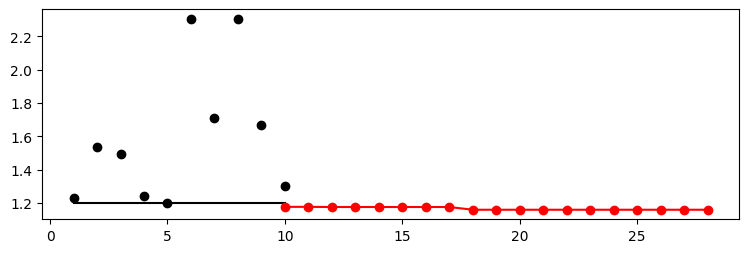

In [22]:
#| echo: true
#| label: fig-progress
#| fig-cap: "Progress plot. *Black* dots denote results from the initial design. *Red* dots  illustrate the improvement found by the surrogate model based optimization."
spot_tuner.plot_progress(log_y=False, filename="./figures" + experiment_name+"_progress.pdf")

![Progress plot. `Black` dots denote results from the initial design. `Red` dots  illustrate the improvement found by the surrogate model based optimization (surrogate model based optimization).](./figures/14-torch_bartz09_30min_10init_2023-05-14_14-45-25_progress.png){#fig-progress}

@fig-progress shows a typical behaviour that can be observed in many hyperparameter studies [@bart21i]: the largest improvement is obtained during the evaluation of the initial design. The surrogate model based optimization-optimization with the surrogate refines the results. @fig-progress also illustrates one major difference between `ray[tune]` as used in @pyto23a and `spotPython`: the `ray[tune]` uses a random search and will generate results similar to the *black* dots, whereas `spotPython` uses a surrogate model based optimization and presents results represented by *red* dots in @fig-progress. The surrogate model based optimization is considered to be more efficient than a random search, because the surrogate model guides the search towards promising regions in the hyperparameter space.

In addition to the improved ("optimized") hyperparameter values, `spotPython` allows a statistical analysis, e.g., a sensitivity analysis, of the results. We can print the results of the hyperparameter tuning, see @tbl-results.

In [23]:
#| echo: true
print(gen_design_table(fun_control=fun_control, spot=spot_tuner))

| name       | type   | default          |   lower |   upper |   tuned | transform             |   importance | stars   |
|------------|--------|------------------|---------|---------|---------|-----------------------|--------------|---------|
| l1         | int    | 5                |     2.0 |     9.0 |     7.0 | transform_power_2_int |       100.00 | ***     |
| l2         | int    | 5                |     2.0 |     9.0 |     3.0 | transform_power_2_int |        96.29 | ***     |
| lr         | float  | 0.001            |   0.001 |   0.001 |   0.001 | None                  |         0.00 |         |
| batch_size | int    | 4                |     1.0 |     5.0 |     4.0 | transform_power_2_int |         0.00 |         |
| epochs     | int    | 3                |     3.0 |     4.0 |     4.0 | transform_power_2_int |         4.18 | *       |
| k_folds    | int    | 2                |     0.0 |     0.0 |     0.0 | None                  |         0.00 |         |
| patience   | int    | 

| name       | type   |   default |   lower |   upper |      tuned | transform             |   importance | stars   |
|------------|--------|-----------|---------|---------|------|-----------------------|--------------|---------|
| l1         | int    |       5.0 |     2.0 |     9.0 |                  6.0 | power_2_int |        74.93 | **      |
| l2         | int    |       5.0 |     2.0 |     9.0 |                  5.0 | power_2_int |         0.00 |         |
| lr         | float  |     0.001 |   1e-05 |    0.01 | 0.0038 | None                  |       100.00 | ***     |
| batch_size | int    |       4.0 |     1.0 |     5.0 |                  4.0 | power_2_int |        75.39 | **      |
| epochs     | int    |       3.0 |     3.0 |     4.0 |                  4.0 | power_2_int |         0.00 |         |
| k_folds    | int    |       2.0 |     0.0 |     0.0 |                  0.0 | None                  |         0.00 |         |
| patience   | int    |       5.0 |     5.0 |     5.0 |                  5.0 | None                  |         0.00 |         |
: Results of the hyperparameter tuning. The table shows the hyperparameters, their types, default values, lower and upper bounds, and the transformation function. The column "tuned" shows the tuned values. The column "importance" shows the importance of the hyperparameters. The column "stars" shows the importance of the hyperparameters in stars. The importance is computed by the SPOT software. {#tbl-results}

To visualize the most important hyperparameters, `spotPython` provides the function `plot_importance`. The following code generates the importance plot from @fig-importance.

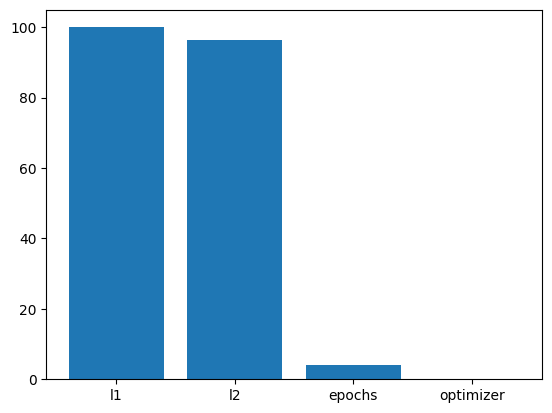

In [24]:
#| echo: true
spot_tuner.plot_importance(threshold=0.025, filename="./figures" + experiment_name+"_importance.pdf")

![Variable importance](./figures/14-torch_bartz09_30min_10init_2023-05-14_14-45-25_importance.png){#fig-importance width="50%"}


## Get SPOT Results {#sec-get-spot-results}

The architecture of the `spotPython` model can be obtained by the following code:

In [25]:
#| echo: true
X = spot_tuner.to_all_dim(spot_tuner.min_X.reshape(1,-1))
model_spot = get_one_core_model_from_X(X, fun_control)
model_spot

Net_CIFAR10(
  (criterion): CrossEntropyLoss()
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=10, bias=True)
)

First, the numerical representation of the hyperparameters are obtained, i.e., the numpy array `X` is generated. This array is then used to generate the model `model_spot` by the function `get_one_core_model_from_X`. The model `model_spot` has the following architecture:


```{raw}
Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
```

## Get Default Hyperparameters

In a similar manner as in @sec-get-spot-results, the default hyperparameters can be obtained.

In [26]:
#| echo: true
# fun_control was modified, we generate a new one with the original default hyperparameters
fc = copy.deepcopy(fun_control)
fc.update({"core_model_hyper_dict": hyper_dict[fun_control["core_model"].__name__]})
model_default = get_one_core_model_from_X(X_start, fun_control=fc)

The corresponding default model has the following architecture:

```{raw}
Net_CIFAR10(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)
```



## Evaluation of the Tuned Architecture

The method `train_save` takes a model architecture without trained weights and trains this model with the train data. The train data is split into train and validation data. The validation data is used for early stopping. The trained model weights are saved as a dictionary.

 This evaluation is similar to the final evaluation in @pyto23a. 


In [27]:
#|echo: true
train_save(net=model_default,train_dataset=train, shuffle=True, device = "cpu", show_batch_interval=1_000, path="model_default_trained.pt", save_model=True)
test_saved(net=model_default,test_dataset=test, shuffle=False, device = "cpu", path="model_default_trained.pt")

Epoch: 1
Batch:  1000. Batch Size: 16. Training Loss (running): 2.309
Loss on hold-out set: 2.30505225982666
Accuracy on hold-out set: 0.0933
Epoch: 2
Batch:  1000. Batch Size: 16. Training Loss (running): 2.305
Loss on hold-out set: 2.302273603439331
Accuracy on hold-out set: 0.10575
Epoch: 3
Batch:  1000. Batch Size: 16. Training Loss (running): 2.302
Loss on hold-out set: 2.298274313735962
Accuracy on hold-out set: 0.1198
Epoch: 4
Batch:  1000. Batch Size: 16. Training Loss (running): 2.297
Loss on hold-out set: 2.285705845451355
Accuracy on hold-out set: 0.1248
Epoch: 5
Batch:  1000. Batch Size: 16. Training Loss (running): 2.277
Loss on hold-out set: 2.2493539297103884
Accuracy on hold-out set: 0.12905
Epoch: 6
Batch:  1000. Batch Size: 16. Training Loss (running): 2.236
Loss on hold-out set: 2.20610922498703
Accuracy on hold-out set: 0.1699
Epoch: 7
Batch:  1000. Batch Size: 16. Training Loss (running): 2.189
Loss on hold-out set: 2.1623984344482423
Accuracy on hold-out set: 0.22

(2.118220252227783, nan)

 The following code trains the model `model_spot` and saves the weights of the trained model to the file `model_spot_trained.pt`.


In [28]:
#| echo: true
train_save(net=model_spot, train_dataset=train,
                shuffle=True, path="model_spot_trained.pt", save_model=True)

Epoch: 1
Loss on hold-out set: 1.609377156829834
Accuracy on hold-out set: 0.3965
Epoch: 2
Loss on hold-out set: 1.4782255734443666
Accuracy on hold-out set: 0.45055
Epoch: 3
Loss on hold-out set: 1.3603773032665252
Accuracy on hold-out set: 0.50185
Epoch: 4
Loss on hold-out set: 1.3327916693210602
Accuracy on hold-out set: 0.51955
Epoch: 5
Loss on hold-out set: 1.2735837899684905
Accuracy on hold-out set: 0.54105
Epoch: 6
Loss on hold-out set: 1.2628570571660995
Accuracy on hold-out set: 0.5467
Epoch: 7
Loss on hold-out set: 1.2253513166427612
Accuracy on hold-out set: 0.5613
Epoch: 8
Loss on hold-out set: 1.2290408061742784
Accuracy on hold-out set: 0.5602
Epoch: 9
Loss on hold-out set: 1.2233493249177934
Accuracy on hold-out set: 0.57855
Epoch: 10
Loss on hold-out set: 1.2161749539613724
Accuracy on hold-out set: 0.5812
Epoch: 11
Loss on hold-out set: 1.1782471472501754
Accuracy on hold-out set: 0.59
Epoch: 12
Loss on hold-out set: 1.189301056933403
Accuracy on hold-out set: 0.59425

(1.2267619131326675, nan)

```{raw}
Loss on hold-out set: 1.1649643966913223
Accuracy on hold-out set: 0.5948
```

In [29]:
#| echo: true
test_saved(net=model_spot, test_dataset=test,
            shuffle=False, path="model_spot_trained.pt")

Loss on hold-out set: 1.242568492603302
Accuracy on hold-out set: 0.5957
Returned to Spot: Validation loss: 1.242568492603302
----------------------------------------------


(1.242568492603302, nan)

```{raw}
Loss on hold-out set: 1.1034918918132781
Accuracy on hold-out set: 0.6184
```


## Comparison with Default Hyperparameters and Ray Tune

@tbl-comparison shows the loss and accuracy of the default model, the model with the hyperparameters from SPOT, and the model with the hyperparameters from `ray[tune]`.

| Model     | Validation Loss | Validation Accuracy | Loss    | Accuracy |
|:----------|----------------:|--------------------:|--------:|---------:|
| Default   | 1.3152          | 0.5316              | 1.1561  | 0.5934   |
| `spotPython`      | 1.0686          | 0.6291             | 1.1035  | 0.6184   |
| `ray[tune]`  | 1.1815          | 0.5836              | -       | 0.5806   |
: Comparison of the loss and accuracy of the default model, the model with the hyperparameters from SPOT, and the model with the hyperparameters from `ray[tune]`. `ray[tune]` only shows the validation loss, because training loss is not reported by `ray[tune]`. {#tbl-comparison}


## Detailed Hyperparameter Plots

The contour plots in this section visualize the interactions of the three most important hyperparameters, `lr`, `batch_size`,  and `l1` of the surrogate model used to optimize the hyperparameters. Since these hyperparameters take integer values, a step-like fitness landcape (or response surface) is generated.
SPOT draws the interactions of the main hyperparameters by default. It is also possible to visualize all interactions. For this, again refer to the notebook [@bart23e].


l1:  99.99999999999999
l2:  96.29169355627103
epochs:  4.181941624789322
optimizer:  0.16219114233665102


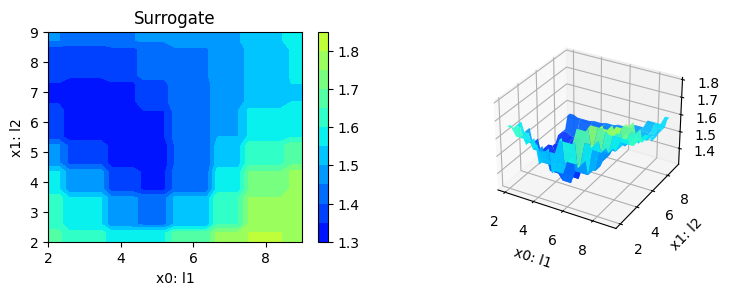

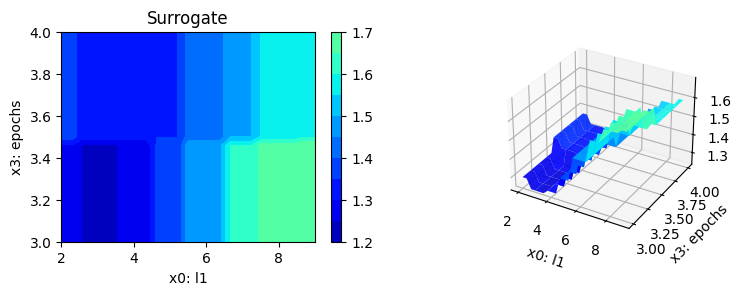

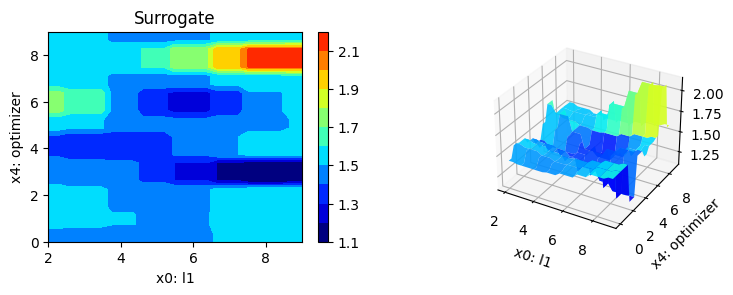

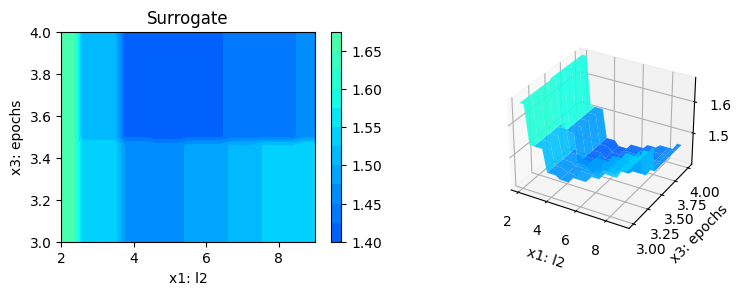

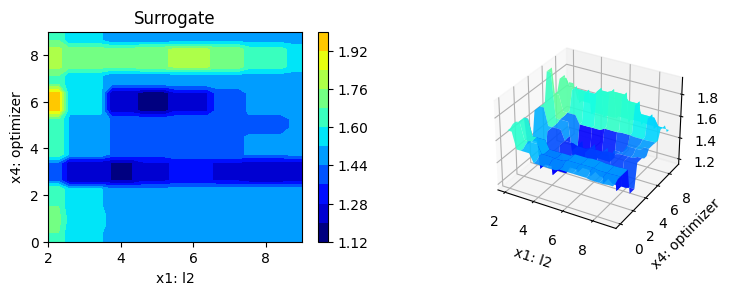

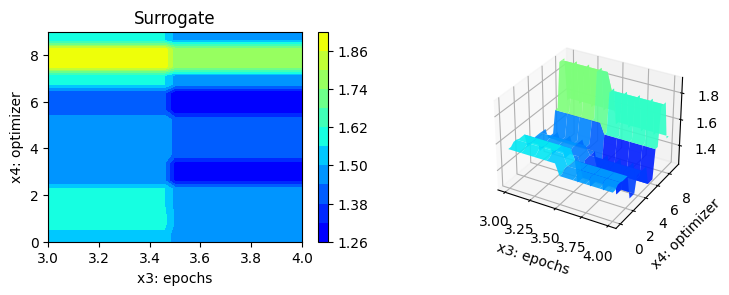

In [30]:
#| echo: true
#| label: fig-contour
threshold = 0.025
impo = spot_tuner.print_importance(threshold=threshold, print_screen=True)
var_plots = [i for i, x in enumerate(impo) if x[1] > threshold]
min_z = min(spot_tuner.y)
max_z = max(spot_tuner.y)
n = spot_tuner.k
for i in var_plots:
    for j in var_plots:
        if j > i:
            filename = "./figures" + experiment_name+"_contour_"+str(i)+"_"+str(j)+".pdf"
            spot_tuner.plot_contour(i=i, j=j, min_z=min_z, max_z = max_z, filename=filename)

![Contour plot. Learning rate versus number of neurons in layer `l1`.](./figures/14-torch_bartz09_30min_10init_2023-05-14_14-45-25_contour_0_2.png){#fig-contour-0-2}

![Contour plot. Batch size versus number of neurons in layer `l1`.](./figures/14-torch_bartz09_30min_10init_2023-05-14_14-45-25_contour_0_3.png){#fig-contour-0-3}

![Contour plot. Batch size versus learning rate.](./figures/14-torch_bartz09_30min_10init_2023-05-14_14-45-25_contour_2_3.png){#fig-contour-2-3}

@fig-contour-0-2 shows the contour plot of the loss as a function of the learning rate and the number of neurons in layer `l1`. The contour plot shows that the learning rate has a strong influence on the performance of the model. Too large values of the learning rate decrease the performance of the neural network. @fig-contour-0-3 and @fig-contour-2-3 indicate that the batch size should be increased. The batch size has a strong influence on the performance of the model. Too small values of the batch size decrease the performance of the neural network.

 `spotPython` provides additional tools for a visual inspection of the results and give valuable insights into the hyperparameter tuning process.
 This is especially useful for model explainability, transparency, and trustworthiness.
In addition to the contour plots, @fig-parallel shows the parallel plot of the hyperparameters.

In [31]:
#| echo: true
#| label: fig-parallel
spot_tuner.parallel_plot()

![Parallel plot](./figures/parallel.png){#fig-parallel}


# Summary and Outlook {#sec-summary}

This tutorial presents the hyperparameter tuning open source software `spotPython` for `PyTorch`. To show its basic features, a comparison with the "official" `PyTorch` hyperparameter tuning tutorial [@pyto23a] is presented.
Some of the advantages of `spotPython` are:

- Numerical and categorical hyperparameters.
- Powerful surrogate models.
- Flexible approach and easy to use.
- Simple JSON files for the specification of the hyperparameters.
- Extension of default and user specified network classes.
- Noise handling techniques.

Currently, only rudimentary parallel and distributed neural network training is possible, but these capabilities will be extended in the future. The next version of `spotPython` will also include a more detailed documentation and more examples.

::: {.callout-important}
Important: This tutorial does not present a complete benchmarking study [@bart20gArxiv]. The results are only preliminary and highly dependent on the local configuration (hard- and software). Our goal is to provide a first impression of the performance of the hyperparameter tuning package `spotPython`. To demonstrate its capabilities, a quick comparison with `ray[tune]` was performed. `ray[tune]` was chosen, because it is presented as "an industry standard tool for distributed hyperparameter tuning."  The results should be interpreted with care.
:::


# Appendix {#sec-appendix}

## Sample Output From Ray Tune's Run {.unnumbered}

The output from `ray[tune]` could look like this [@pyto23b]:

```{raw}
Number of trials: 10 (10 TERMINATED)
------+------+-------------+--------------+---------+------------+--------------------+
|   l1 |   l2 |          lr |   batch_size |    loss |   accuracy | training_iteration |
+------+------+-------------+--------------+---------+------------+--------------------|
|   64 |    4 | 0.00011629  |            2 | 1.87273 |     0.244  |                  2 |
|   32 |   64 | 0.000339763 |            8 | 1.23603 |     0.567  |                  8 |
|    8 |   16 | 0.00276249  |           16 | 1.1815  |     0.5836 |                 10 |
|    4 |   64 | 0.000648721 |            4 | 1.31131 |     0.5224 |                  8 |
|   32 |   16 | 0.000340753 |            8 | 1.26454 |     0.5444 |                  8 |
|    8 |    4 | 0.000699775 |            8 | 1.99594 |     0.1983 |                  2 |
|  256 |    8 | 0.0839654   |           16 | 2.3119  |     0.0993 |                  1 |
|   16 |  128 | 0.0758154   |           16 | 2.33575 |     0.1327 |                  1 |
|   16 |    8 | 0.0763312   |           16 | 2.31129 |     0.1042 |                  4 |
|  128 |   16 | 0.000124903 |            4 | 2.26917 |     0.1945 |                  1 |
+-----+------+------+-------------+--------------+---------+------------+--------------------+
Best trial config: {'l1': 8, 'l2': 16, 'lr': 0.00276249, 'batch_size': 16, 'data_dir': '...'}
Best trial final validation loss: 1.181501
Best trial final validation accuracy: 0.5836
Best trial test set accuracy: 0.5806
```



{{< pagebreak >}}

# References {.unnumbered}

::: {#refs}
:::